## Approximating the `Sine` Function using QML

The idea here is to use a parametrized circuit whose expectation value will be the approximation of the sine function.  

In our solution, we use a single qubit for the circuit. We encode the value of x into the circuit by performing an RY operation with the value of x, since x is also the angle and lies in the range of $[0, 2\pi]$.  

We define a layer to contain a single parametrized rotation operator. The `qml.Rot` function takes in three parameters that define a rotation in the Bloch Sphere. It is these three parameters, along with a classical "bias" parameter, that we want to optimize to approximate the sine function as the `Z` expectation value of the qubit.

We borrow basic code structure and lessons learned from Task 2, and make modifications on the same to train our model.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
# set up device
dev = qml.device("default.qubit")

In [3]:
def state_preparation(x):
    qml.RY(x, wires=0)

In [4]:
def layer(layer_weights):
    qml.Rot(*layer_weights[0], wires=0)

In [5]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [6]:
def sine_func(weights, bias, x):
    return circuit(weights, x) + bias

In [7]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [8]:
def cost(weights, bias, X, Y):
    predictions = [sine_func(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [9]:
# Visualize circuit
print(qml.draw(circuit, expansion_strategy="device")([[[0,0,0]]], 0))

0: ──RY(0.00)──Rot(0.00,0.00,0.00)─┤  <Z>


#### Create Datasets

We discretize the interval of $[0, 2\pi]$ into $10000$ points for the sake of continuity. But we only sample a total of hundred of those discretized values to train and test our data. The sampling is random, and the allotment of the sample into the train/test datasets is also random while maintaining a ratio of Train : Test = 80 : 20

In [10]:
# preparation of input values in the range of [0, 2*pi)
values = np.linspace(0, 2*np.pi, 10000)

In [11]:
# random distribution of data into 80:20 ratio for train:test

sets = {'train': {'x': [], 'y': []}, 'test': {'x': [], 'y': []}}

# generate a hundred sample indices, and append the corresponding x and sin(x) values
# into the train and test datasets in the ratio of 80:20
indx = np.random.randint(0, 10000, 100)
for i in indx:
    if np.random.rand() < 0.8:
        sets['train']['x'].append(values[i])
        sets['train']['y'].append(np.sin(values[i]))
    else:
        sets['test']['x'].append(values[i])
        sets['test']['y'].append(np.sin(values[i]))        

#### Optimization

We propose an ansatz of `num_layers = 1`, and randomly initialize weights and biases close to zero.

In [12]:
np.random.seed(0)
num_qubits = 1
num_layers = 1
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[0.01764052 0.00400157 0.00978738]]]
Bias:  0.0


We use the Nesterov Momentum Optimizer, with a step size of 0.3.  
We set the batch size to 16 since that's neither a lot nor too less, for performing Stochastic Gradient Descent on a total of 100 samples. Seems optimal.

In [13]:
opt = NesterovMomentumOptimizer(0.3)
batch_size = 16

Train as usual, for 40 epochs

In [14]:
weights = weights_init
bias = bias_init

# costs array to record the cost at each iteration, useful for plot
costs = []
for it in range(40):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(sets['train']['x']), (batch_size,))
    batch_index = np.array(batch_index, dtype=int)
    X_batch = np.array(sets['train']['x'])[batch_index]
    Y_batch = np.array(sets['train']['y'])[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute cost and append to memory
    current_cost = cost(weights, bias, sets['train']['x'], sets['train']['y'])
    costs.append(current_cost)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f}")

Iter:    1 | Cost: 0.6011005
Iter:    2 | Cost: 0.3022990
Iter:    3 | Cost: 0.0608219
Iter:    4 | Cost: 0.0141797
Iter:    5 | Cost: 0.0732037
Iter:    6 | Cost: 0.0815788
Iter:    7 | Cost: 0.0378652
Iter:    8 | Cost: 0.0074276
Iter:    9 | Cost: 0.0003208
Iter:   10 | Cost: 0.0030687
Iter:   11 | Cost: 0.0065491
Iter:   12 | Cost: 0.0072673
Iter:   13 | Cost: 0.0041950
Iter:   14 | Cost: 0.0012684
Iter:   15 | Cost: 0.0000256
Iter:   16 | Cost: 0.0002059
Iter:   17 | Cost: 0.0005858
Iter:   18 | Cost: 0.0004764
Iter:   19 | Cost: 0.0002125
Iter:   20 | Cost: 0.0000174
Iter:   21 | Cost: 0.0000130
Iter:   22 | Cost: 0.0000551
Iter:   23 | Cost: 0.0000592
Iter:   24 | Cost: 0.0000377
Iter:   25 | Cost: 0.0000087
Iter:   26 | Cost: 0.0000001
Iter:   27 | Cost: 0.0000026
Iter:   28 | Cost: 0.0000066
Iter:   29 | Cost: 0.0000036
Iter:   30 | Cost: 0.0000016
Iter:   31 | Cost: 0.0000002
Iter:   32 | Cost: 0.0000002
Iter:   33 | Cost: 0.0000006
Iter:   34 | Cost: 0.0000006
Iter:   35 | C

#### Plots

In [15]:
import matplotlib.pyplot as plt

Use the final weights and bias obtained post-training to compute the circuit's function approximation on both train and test datasets and plot them.

In [16]:
train_results = {'x': [], 'y': []}
for x in sets['train']['x']:
    train_results['x'].append(x)
    train_results['y'].append(sine_func(weights, bias, x))

test_results = {'x': [], 'y': []}
for x in sets['test']['x']:
    test_results['x'].append(x)
    test_results['y'].append(sine_func(weights, bias, x))

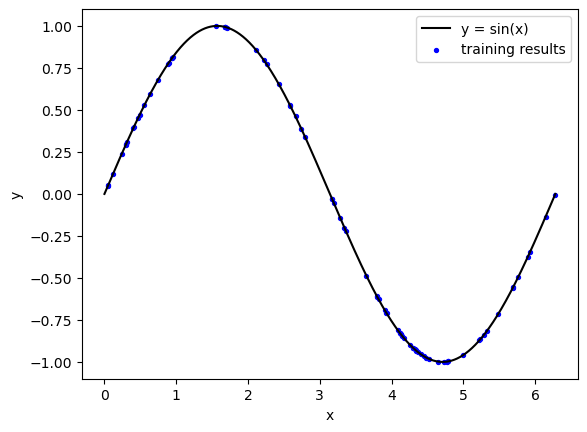

In [17]:
plt.plot(values, np.sin(values), color = 'black', label = 'y = sin(x)')
plt.scatter(train_results['x'], train_results['y'], color = 'blue', label = 'training results', s = 8)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

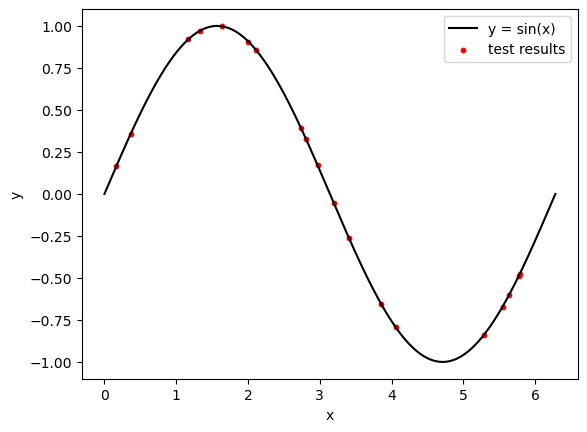

In [18]:
plt.plot(values, np.sin(values), color = 'black', label = 'y = sin(x)')
plt.scatter(test_results['x'], test_results['y'], color = 'red', label = 'test results', s = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Plot the Average Cost vs Iteration during training

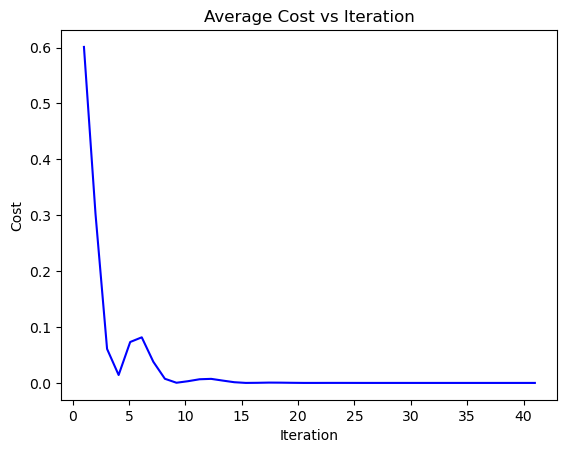

In [19]:
iterations = np.linspace(1, 41, 40)

plt.plot(iterations, costs, color = 'blue')
plt.title('Average Cost vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

### Conclusion

Our ansatz of the circuit turned out to be a very good guess. The circuit learned to approximate the sine function very accurately in about 30-35 epochs. It only needed one layer of gates, which in itself consisted only a single Rotation operator. This can be seen as an improvement over the classical NN approach where we required hundreds of parameteres in a total of three hidden layers to approximate the sine function. Despite that, the cost incurred was of the order of $10^{-3}$ in that case, whereas it basically dropped to zero (at least upto 7 decimal digits) in the case of the QML approach.